# Get Current Forecast

read out the forecast for different companies for today. Source of forecast data is [https://kursprognose.com](https://kursprognose.com)

In [3]:
from finance_monitor.forecastgrapper import ForecastGrapper
fcg = ForecastGrapper()

Forecast data saved to 20250408_nvidia_forecast.csv
Forecast data saved to 20250408_nvidia_forecast.csv
Current stock price of nvidia is 98.64 USD / 90.04 EUR


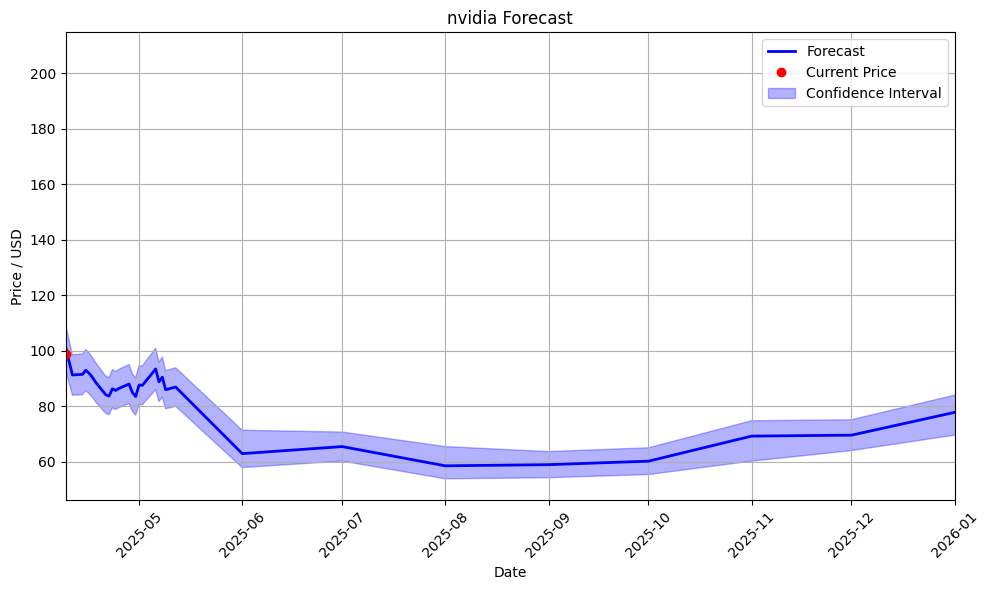

In [4]:
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250408_rhm-aktie_forecast.csv
Forecast data saved to 20250408_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1410.0 USD / 1287.05 EUR


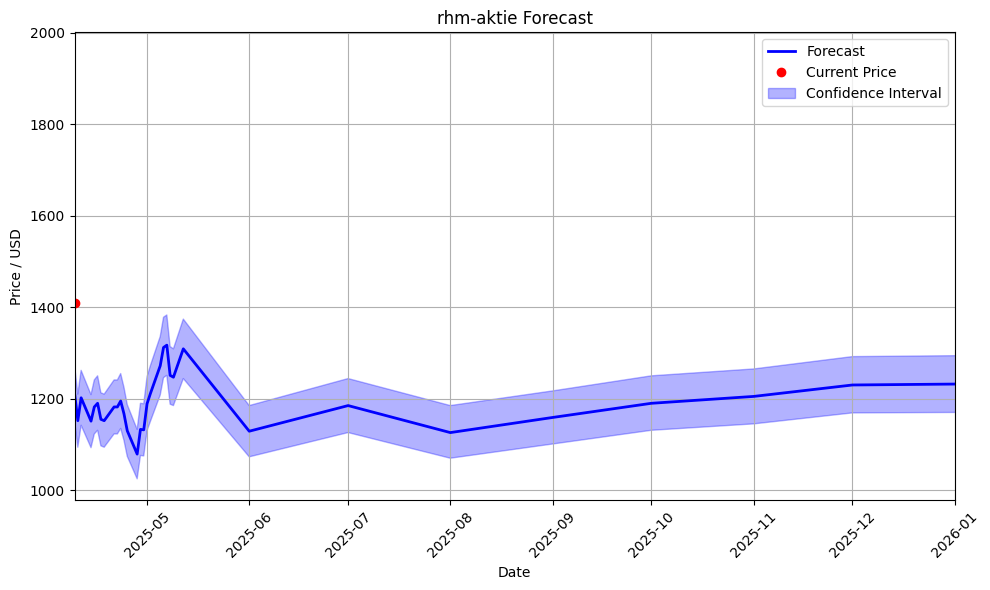

In [5]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250408_tesla_forecast.csv
Forecast data saved to 20250408_tesla_forecast.csv
Current stock price of tesla is 228.23 USD / 208.33 EUR


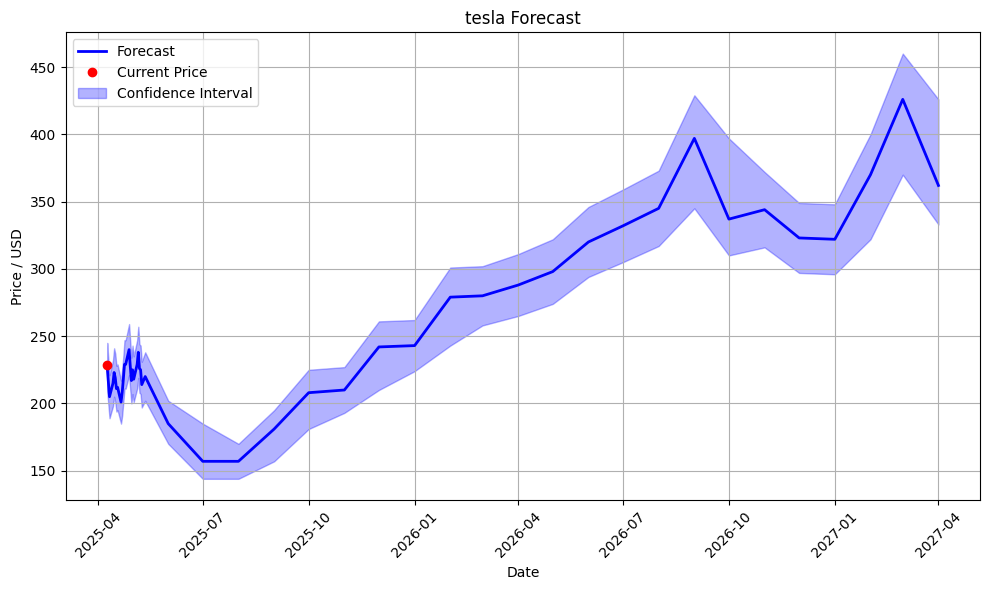

In [6]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250408_netflix_forecast.csv
Forecast data saved to 20250408_netflix_forecast.csv
Current stock price of netflix is 878.04 USD / 801.47 EUR


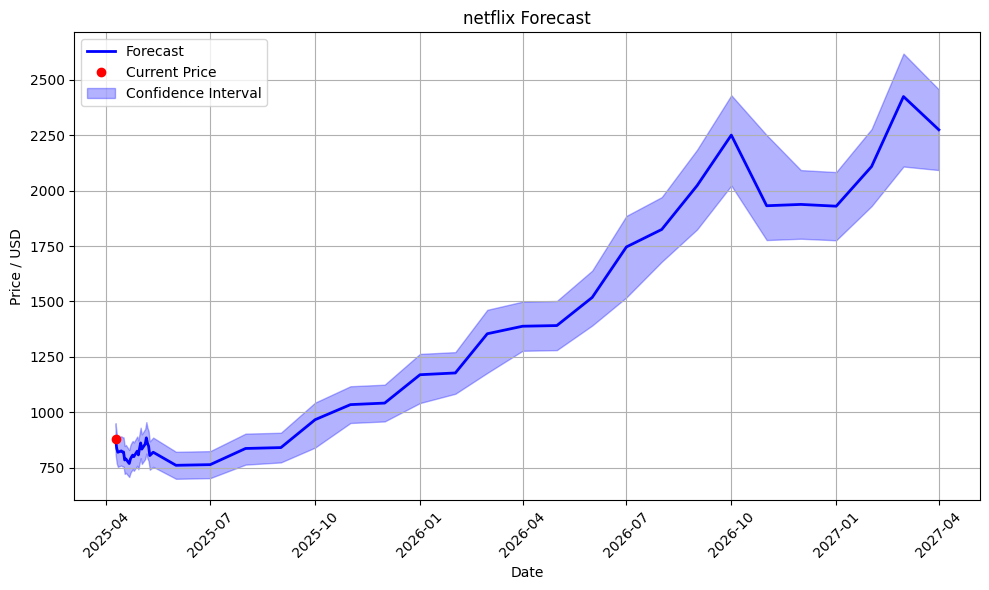

In [7]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250408_wmt-stock_forecast.csv
Forecast data saved to 20250408_wmt-stock_forecast.csv
Current stock price of wmt-stock is 82.94 USD / 75.69 EUR


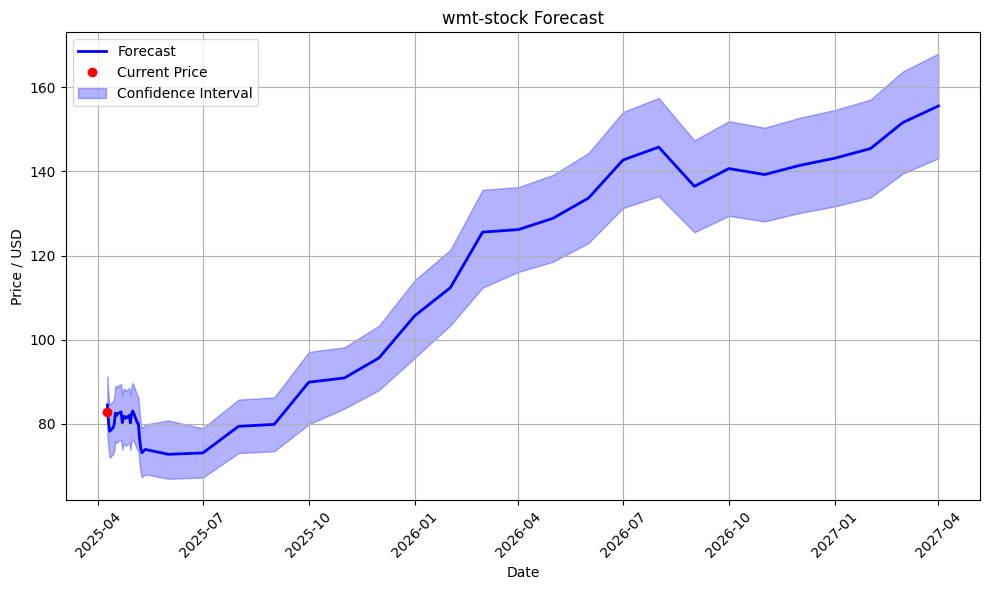

In [8]:
fcg.set_company("wmt-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250408_xpeng_forecast.csv
Forecast data saved to 20250408_xpeng_forecast.csv
Current stock price of xpeng is 16.41 USD / 14.98 EUR


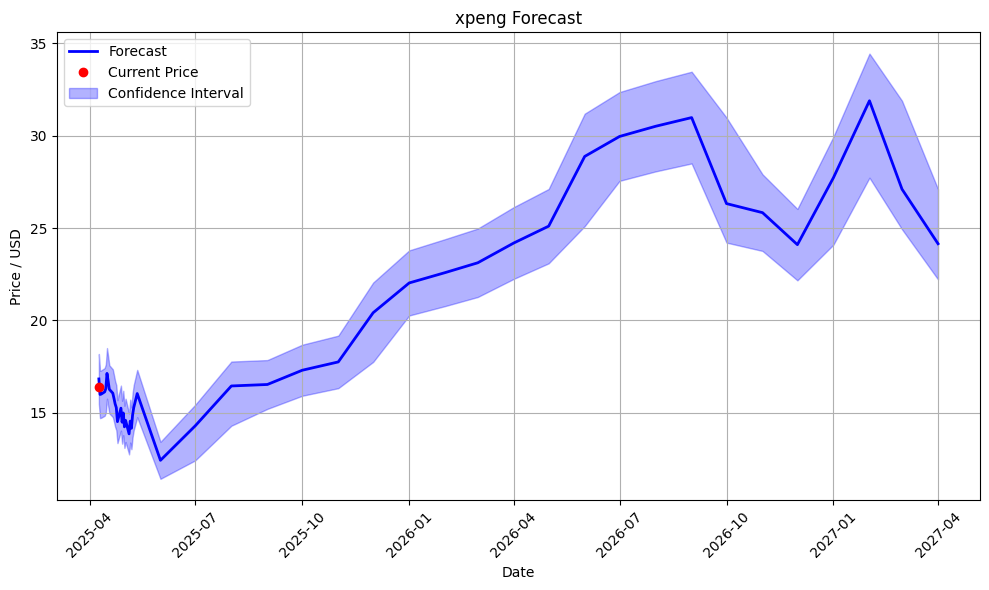

In [9]:
fcg.set_company("xpeng")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250408_mo-stock_forecast.csv
Forecast data saved to 20250408_mo-stock_forecast.csv
Current stock price of mo-stock is 55.71 USD / 50.84 EUR


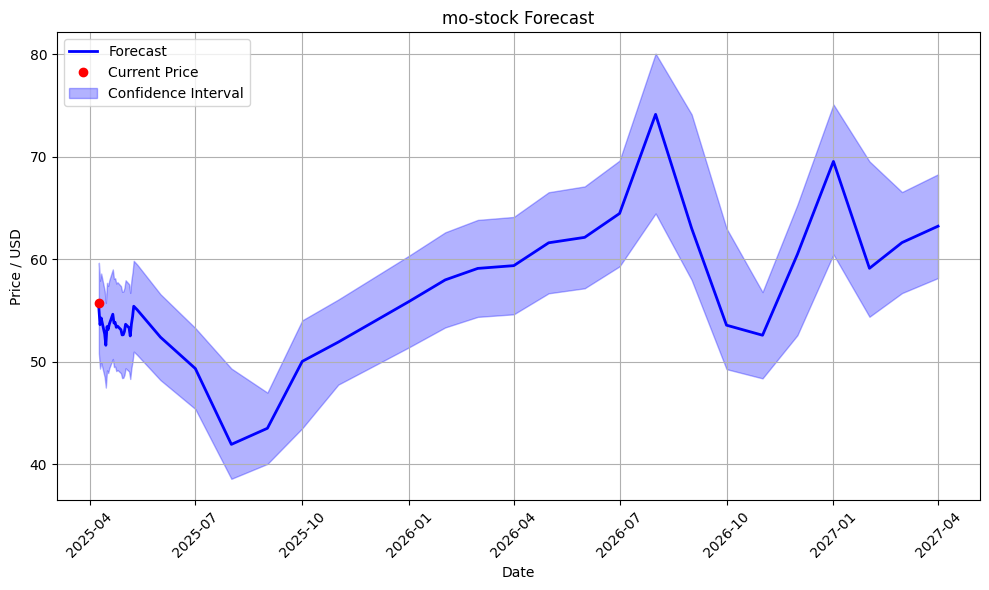

In [10]:
fcg.set_company("mo-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()